# Recherche d'information dans la littérature scientifique

**MOD 7.2 (Introduction à la sciences des données)**, BE séances 4, 5, 6

**Enseignants :** Julien Velcin (CM, BE), Erwan Versmée (BE)

Le projet qu'on vous demande de réaliser est un **moteur de recherche** qui, étant donnée une publication, retourne les articles qui en sont le plus proche sémantiquement.
Pour simplifier le problème, pour une **requête donnée** (*query*), càd un article, on vous fournit 5 articles cités par celui-ci (les exemples positifs) et environ 25 articles choisis aléatoirement dans la base (les exemples négatifs).

La tâche consiste alors à construire un algorithme capable de **retourner les 5 citations et écarter les autres**.

Notez, qu'en plus du titre, d'**autres informations** susceptibles d'être utiles vous sont fournies : court résumé textuel, auteur(s) de l’article, année de publication, références bibliographiques, quels autres articles le citent.

**Exemple :**

Titre de l'article ciblé (notre requête, pour simplifier) : *"Bearish-Bullish Sentiment Analysis on Financial Microblogs"*

Quelques exemples positifs :

> "SemEval-2015 Task 11: Sentiment Analysis of Figurative Language in Twitter"
>
> "Text mining of news-headlines for FOREX market prediction: A Multi-layer Dimension Reduction Algorithm with semantics and sentiment"

Quelques exemples négatifs :

> "Analysis and Design of Average Current Mode Control Using a Describing-Function-Based Equivalent Circuit Model"
>
> "MVOR: A Multi-view RGB-D Operating Room Dataset for 2D and 3D Human Pose Estimation"


Votre moteur se basera sur un système *S* qui doit mesurer à quel point un article candidat *c* répond bien à la requête *q* à l'aide d'un **score d'appariement** S(q,c) : plus ce score est élevé, mieux l'article correspond à la requête.

Si *q* est la requête et *C* l'ensemble des candidats (environ 25 pour chaque requête), composés d'exemples positifs *C+* et négatifs *C-*, alors il faut que *S* retourne préférentiellement les exemples de *C+*, donc leur attribue un score important.


## Setup and Import Libraries

Ici se trouvent un certain nombre de librairies dont vous pourriez avoir besoin. Néanmoins, rien ne vous oblige à tout utiliser et vous pouvez ajouter vos propres librairies. Il est cependant important qu'il soit possible pour une tierce personne d'installer le nécessaire pour exécuter votre code.

In [1]:
import json
import numpy as np
import networkx as nx
from collections import defaultdict, Counter
from typing import Dict, List, Tuple
import os
import pickle
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')

# For embeddings and similarity computation
try:
    from sentence_transformers import SentenceTransformer
    from sklearn.metrics.pairwise import cosine_similarity
    print("Required libraries imported successfully!")
except ImportError as e:
    print(f"Missing library: {e}")
    print("Please install with: pip install sentence-transformers scikit-learn networkx")

np.random.seed(42)

Required libraries imported successfully!


Le code qui suit peut être utile pour réaliser des affichages à partir de la matrice Documents x Termes, libre à vous de l'utiliser.

In [2]:
from scipy.sparse import find, csr_matrix
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import norm
from IPython.core.display import HTML


# des options permettent de limiter (ou non) le nombre de lignes/colonnes affichées
# par exemple :
# pd.set_option('display.max_rows', None)

# cette fonction permet d'afficher une "jolie" représentation du vecteur v
# ARGS :
#   v : le vecteur à afficher (par ex. une ligne de la matrice X)
#   features : le vocabulaire
#   top_n : le nombre de mots maximum à afficher

def print_feats(v, features, top_n = 30):
    _, ids, values = find(v)
    feats = [(ids[i], values[i], features[ids[i]]) for i in range(len(list(ids)))]
    top_feats = sorted(feats, key=lambda x: x[1], reverse=True)[0:top_n]
    return pd.DataFrame({"word" : [t[2] for t in top_feats], "value": [t[1] for t in top_feats]})   

# fonction qui permet d'afficher plusieurs tables pandas côte à côte (c'est cadeau)
def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "&emsp;"
        #output += "\xa0\xa0\xa0"
    display(HTML(output))

## 1. Chargement et prise en main des données

La première étape consiste bien entendu à charger les données en mémoire et aller voir comment celles-ci sont structurées. On vous fournit 3 fichiers pour commencer :

- *corpus.jsonl* : le corpus lui-même, composé de plus de 25k articles scientifiques
- *queries.jsonl* : l'ensemble des documents qui constituent les requêtes qui seront adressées à notre moteur. Ces documents proviennent du corpus, mais il peut s'agir de documents qui ne sont que cités ou citent d'autres documents et pour lesquels on n'a que très peu d'information.
- *valid.tsv* : l'ensemble des données nécessaires pour entraîner et/ou tester votre moteur

Voilà un extrait du fichier *corpus.jsonl* :

![corpus](./corpus.jpg "Title")

Voilà un extrait du fichier *queries.jsonl* :

![corpus](./queries.jpg "Title")

Voilà un extrait du fichier *valid.tsv* :

![corpus](./test.jpg "Title")

Par la suite, on vous fournira à priori un 4ème fichier (*test_final.tsv*) qui contiendra des nouvelles données sur lesquelles vous pourrez réaliser  des prédictions. Les identifiants des candidats sont toujours tirés de votre corpus d'articles.

Nous vous conseillons d'employer la libraire *json* pour charger les données des deux premiers fichiers et utiliser des dictionnaires afin de pouvoir accéder aux articles via leurs identifiants. Pour rappel, un fichier *jsonl* n'est rien d'autre qu'un fichier dans lequel chaque ligne est composé d'un objet json bien formaté.

In [179]:
def load_corpus(file_path: str) -> Dict[str, Dict]:
    """
    TODO

    Load corpus data from JSONL file.
    Returns dictionary mapping document IDs to document data.
    """
    corpus = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            doc = json.loads(line)
            corpus[doc['_id']] = doc
    return corpus

In [178]:

def load_queries(file_path: str) -> Dict[str, Dict]:
    """
    TODO

    Load query data from JSONL file.
    Returns dictionary mapping query IDs to query data.
    """
    queries = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            query = json.loads(line)
            queries[query['_id']] = query
    return queries

In [180]:
def load_qrels(file_path: str) -> Dict[str, Dict[str, int]]:
    """
    TODO
    
    Load relevance judgments from TSV file.
    Returns dictionary mapping query IDs to candidate relevance scores.
    """
    valid_tsv = []
    for line in open(file_path, 'r', encoding='utf-8'):
        qid,docid, score = line.strip().split('\t')
        if score not in ['0','1']:
            continue
        valid_tsv.append([qid, docid, int(score)])
    return pd.DataFrame(valid_tsv, columns=['query-id', 'corpus-id', 'score'],index=None)

In [181]:
# Load the dataset
print("Loading dataset...")
corpus = load_corpus('dataset_BE2/corpus.jsonl')
queries = load_queries('dataset_BE2/queries.jsonl')
qrels_valid = load_qrels('dataset_BE2/valid.tsv')


print(f"Loaded {len(corpus)} documents in corpus")
print(f"Loaded {len(queries)} queries")
print(f"Loaded relevance for {len(qrels_valid)} queries (dataset)")

Loading dataset...
Loaded 25657 documents in corpus
Loaded 1000 queries
Loaded relevance for 20950 queries (dataset)


In [122]:
qrels_valid

,query-id,corpus-id,score
0,40c6b953b5c04b3df4164cd487c4bc00cf0e487d,58ab158785a0899210369f76025c1e33c19299f5,0
1,40c6b953b5c04b3df4164cd487c4bc00cf0e487d,8a5444e350e59f69ddf37121d9ede8a818f54a3d,0
2,40c6b953b5c04b3df4164cd487c4bc00cf0e487d,cdb5e5d28a9bd6a04f969d6465110f875e706e71,0
3,40c6b953b5c04b3df4164cd487c4bc00cf0e487d,086cde207a125816091c34a076b473a465b5388f,0
4,40c6b953b5c04b3df4164cd487c4bc00cf0e487d,56b58ead464ea57ce3628742bf681298f603a68b,0
...,...,...,...
20945,7740048416e8f39c3d6eb4f3ee02ca2dfd3590bb,7e23f2bb61e32f50cda4014b404ab69b23cf5c56,0
20946,7740048416e8f39c3d6eb4f3ee02ca2dfd3590bb,fd21cfb3b3a573c9ba0de366605e194b14d00d46,0
20947,7740048416e8f39c3d6eb4f3ee02ca2dfd3590bb,79ea39418cd05977830cbcf2d07a546cec0ab129,1
20948,7740048416e8f39c3d6eb4f3ee02ca2dfd3590bb,519da94369c1d87e09c592f239b55cc9486b5b7c,0


In [ ]:
print(list(corpus.keys())[:5])
print(corpus.values())

In [8]:
print(list(queries.keys())[:5])
print(queries[1].keys())

[0, 1, 2, 3, 4]
dict_keys(['_id', 'text', 'metadata'])


In [9]:
list(qrels_valid.keys())[:5]

['40c6b953b5c04b3df4164cd487c4bc00cf0e487d',
 '2dbe49d7c9a65656cd46d22ea07dc317b26482b6',
 '54356ff0960100e27cf17ff682825bba2662e90c',
 'f1256b20d202c73022d7a7f0151ba0010a074a06',
 '8cb5835c4b4e042238304bfe7b0d96456714638a']

## 2. Exploration des données et premier encodage

A présent, on vous propose de réaliser un certain nombre d'opérations pour mieux connaître vos données. Tout d'abord, il s'agit de calculer des statistiques simples telles que :

- Taille du corpus et du nombre de requêtes
- Nombre de paires requête / document
- Proportions de documents pertinents (non pertinents) par requête

Affichez ensuite un exemple de requête (vous pouvez vous limiter au titre de l'article), accompagnée d'exemples de candidats positifs et de candidats négatifs.

In [10]:
# TODO
# titre de la query 0 
print(queries[0]['text'])
print(qrels_valid[queries[0]['_id']])

A Direct Search Method to solve Economic Dispatch Problem with Valve-Point Effect
{'1ae0ac5e13134df7a0d670fc08c2b404f1e3803c': 0, '73a7144e072356b5c9512bd4a87b22457d33760c': 0, 'c9d41f115eae5e03c5ed45c663d9435cb66ec942': 0, '86e87db2dab958f1bd5877dc7d5b8105d6e31e46': 1, '6c9bd4bd7e30470e069f8600dadb4fd6d2de6bc1': 0, '9f234867df1f335a76ea07933e4ae1bd34eeb48a': 0, '506d4ca228f81715946ed1ad8d9205fad20fddfe': 0, '4114c89bec92ebde7c20d12d0303281983ed1df8': 0, '8e508720cdb495b7821bf6e43c740eeb5f3a444a': 0, '506172b0e0dd4269bdcfe96dda9ea9d8602bbfb6': 1, '1b2a0e8af5c1f18e47e71244973ce4ace4ac6034': 0, '7d3c9c4064b588d5d8c7c0cb398118aac239c71b': 0, '772205182fbb6ad842df4a6cd937741145eeece0': 0, '585da6b6355f3536e1b12b30ef4c3ea54b955f2d': 0, 'b579366db457216b0548220bf369ab9eb183a0cc': 0, '12f107016fd3d062dff88a00d6b0f5f81f00522d': 0, '51317b6082322a96b4570818b7a5ec8b2e330f2f': 1, '22fc3af1fb55d48f3c03cd96f277503e92541c60': 0, 'd18cc66f7f87e041dec544a0b843496085ab54e1': 0, 'f69253e97f487b9d77b7255

Ensuite, utilisez la librairie *scikit-learn* pour réaliser un **premier encodage des données** sous forme de matrice Documents * Termes.
Il suffit pour cela d'utiliser la classe *CountVectorizer* puis d'utiliser les fonction *fit* et *transform* pour (respectivement) construire le vocabulaire et la matrice elle-même.
Pour simplifier et accélérer les calculs, vous pouvez commencer en ne considérant que le titre des articles, mais rien ne vous empêche par la suite d'utiliser également le champ résumé.

Pour le moment, contentez-vous d'utiliser les paramètres par défaut, mais vous pourrez ensuite appliquer de **nombreux prétraitements** tels que la suppression des mots-outils ou la réduction de la taille du vocabulaire. Nous verrons ça dans la section suivante.

In [11]:

corpus[0].keys()

dict_keys(['_id', 'title', 'text', 'metadata'])

In [30]:
# TODO
from sklearn.feature_extraction.text import CountVectorizer
# stop_words='english' ajoute le filtrage des mots vides en anglais
counter_summary = CountVectorizer(stop_words='english')
counter_title = CountVectorizer(stop_words='english')
matrix_doc_summary = counter_summary.fit_transform([corpus[i]['text'] for i in range(len(corpus))])
matrix_doc_summary_title = counter_title.fit_transform([corpus[i]['title'] for i in range(len(corpus))])

In [31]:
matrix_doc_summary.shape

(25657, 76677)

En utilisant la fonction fournie *print_feats*, affichez les informations contenues dans quelques vecteurs de la base de données.

In [32]:
'the' in counter_summary.get_feature_names_out()

False

#### Recherche en utilisant le resumé

In [33]:
print_feats(matrix_doc_summary[0], counter_summary.get_feature_names_out(),top_n=10)

,word,value
0,recurrent,8
1,elites,6
2,network,6
3,hgapso,5
4,design,4
5,enhanced,4
6,fuzzy,4
7,neural,4
8,new,4
9,pso,4


In [34]:
# TODO
list_affichage = []
for i in range(5):
    list_affichage.append(print_feats(matrix_doc_summary[i], counter_summary.get_feature_names_out(),top_n=10))
display_side_by_side(list_affichage, [f"Document {i}" for i in range(5)])

,word,value
0,recurrent,8
1,elites,6
2,network,6
3,hgapso,5
4,design,4
5,enhanced,4
6,fuzzy,4
7,neural,4
8,new,4
9,pso,4


Affichez la distribution des mots les plus fréquemment employés dans le corpus. Pour cela, il suffit de faire la somme des occurrences par colonne, puis d'appeler la fonction d'affichage précédente. Ensuite, vous pouvez utiliser la librairie *matplotlib* pour afficher un histogramme qui permet d'avoir une représentation visuelle de cette distribution.

In [35]:
# TODO
import matplotlib.pyplot as plt
sum_occurences = np.array(matrix_doc_summary.sum(axis=0)).flatten()


Sans stopwords removed


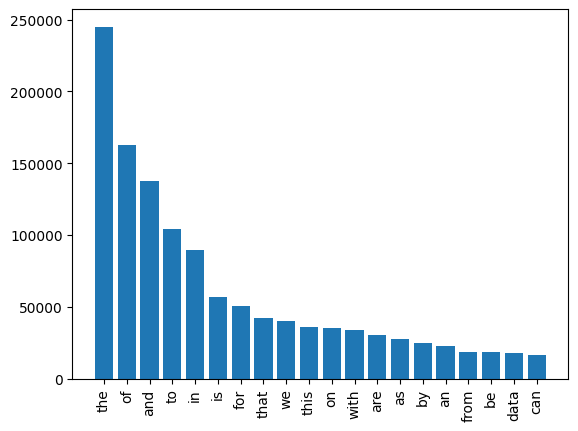

In [18]:
list_sorted = [(num, feat) for feat, num in zip(counter_summary.get_feature_names_out(), sum_occurences)]
list_sorted.sort(reverse=True)
plt.bar([x[1] for x in list_sorted[:20]], [x[0] for x in list_sorted[:20]])
plt.xticks(rotation=90)
plt.show()
# print(list_sorted[:10])

On remarque que trop de stop words sont les plus fréquents ce qui est normale mais qui ne vont pas améliorer notre recherche sémantique

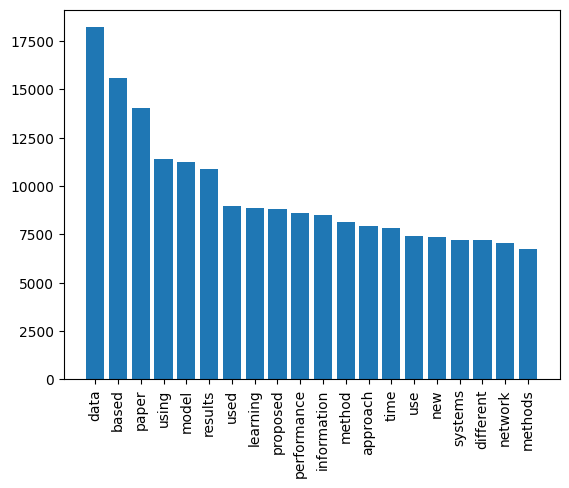

In [36]:
from stopwords import get_stopwords
stop_words = get_stopwords('en')
list_sorted_wo_sw = [(num, feat) for feat, num in zip(counter_summary.get_feature_names_out(), sum_occurences)]
list_sorted_wo_sw.sort(reverse=True)
plt.bar([x[1] for x in list_sorted_wo_sw[:20]], [x[0] for x in list_sorted_wo_sw[:20]])
plt.xticks(rotation=90)
plt.show()


Amélioration apparente des mots les plus fréquents, on voit que les mots qui ont du sens avec les sujets recherchés

## 3. Comparaison de documents et premier moteur de recherche

Une manière classique de comparer des vecteurs creux (ce qui est le cas pour la matrice Documents x Termes) est d'utiliser la mesure du cosinus. Celle-ci calcule une **similarité entre deux textes** basée sur les mots en commun.

En utilisant la fonction *cosine_similarity* de la *librairie sklearn*, testez cette mesure sur différentes paires de texte. Vous pouvez également travailler avec les résumés des articles. N'hésitez pas à afficher les documents pour observer les mots qu'ils ont en commun.

In [37]:
# TODO
from sklearn.metrics.pairwise import cosine_similarity
# pour le text de la query 0
results = {}
for j in range(len(corpus)):
    sim_summary = cosine_similarity(matrix_doc_summary[0], matrix_doc_summary[j])
    sim_title = cosine_similarity(matrix_doc_summary_title[0], matrix_doc_summary_title[j])

    results[j] = {'summary': sim_summary[0][0], 'title': sim_title[0][0]}


In [38]:
results = pd.DataFrame.from_dict(results, orient='index')

# Remettre l’index comme colonne "id"
results = results.reset_index().rename(columns={'index': 'id'})
results.sort_values(by='summary', ascending=False).head(10)

,id,summary,title
0,0,1.000000,1.000000
23585,23585,0.377991,0.353553
4635,4635,0.330395,0.000000
2609,2609,0.319204,0.210819
5239,5239,0.307028,0.000000
10843,10843,0.305412,0.222222
21263,21263,0.304528,0.111111
5091,5091,0.296487,0.117851
4,4,0.281134,0.111111
4035,4035,0.273963,0.149071


#### Résultat obtenu sans enlever les stops words

Comparaison entre les résultats de recherche par résumé et titre

In [28]:
print(corpus[0]['title'])
print(corpus[2629]['title'])
print(corpus[16323]['title'])

A hybrid of genetic algorithm and particle swarm optimization for recurrent network design
Improving returns on stock investment through neural network selection
Deep HyperNEAT : Evolving the Size and Depth of the Substrate Evolutionary


In [29]:
print(corpus[0]['text'])
print(corpus[2629]['text'])
print(corpus[16323]['text'])

An evolutionary recurrent network which automates the design of recurrent neural/fuzzy networks using a new evolutionary learning algorithm is proposed in this paper. This new evolutionary learning algorithm is based on a hybrid of genetic algorithm (GA) and particle swarm optimization (PSO), and is thus called HGAPSO. In HGAPSO, individuals in a new generation are created, not only by crossover and mutation operation as in GA, but also by PSO. The concept of elite strategy is adopted in HGAPSO, where the upper-half of the best-performing individuals in a population are regarded as elites. However, instead of being reproduced directly to the next generation, these elites are first enhanced. The group constituted by the elites is regarded as a swarm, and each elite corresponds to a particle within it. In this regard, the elites are enhanced by PSO, an operation which mimics the maturing phenomenon in nature. These enhanced elites constitute half of the population in the new generation, 

#### En enlevant les stopwords

In [39]:
print(corpus[0]['title'])
print(corpus[23585]['title'])
print(corpus[4635]['title'])

A hybrid of genetic algorithm and particle swarm optimization for recurrent network design
A real-coded genetic algorithm for training recurrent neural networks
Training RNN simulated vehicle controllers using the SVD and evolutionary algorithms


In [40]:
print(corpus[0]['text'])
print(corpus[23585]['text'])
print(corpus[4635]['text'])

An evolutionary recurrent network which automates the design of recurrent neural/fuzzy networks using a new evolutionary learning algorithm is proposed in this paper. This new evolutionary learning algorithm is based on a hybrid of genetic algorithm (GA) and particle swarm optimization (PSO), and is thus called HGAPSO. In HGAPSO, individuals in a new generation are created, not only by crossover and mutation operation as in GA, but also by PSO. The concept of elite strategy is adopted in HGAPSO, where the upper-half of the best-performing individuals in a population are regarded as elites. However, instead of being reproduced directly to the next generation, these elites are first enhanced. The group constituted by the elites is regarded as a swarm, and each elite corresponds to a particle within it. In this regard, the elites are enhanced by PSO, an operation which mimics the maturing phenomenon in nature. These enhanced elites constitute half of the population in the new generation, 

Vous pouvez à présent écrire un **petit moteur de recherche** qui prend un ensemble de mots clefs, calcule un score pour chaque document de la base et retourne les 10 premieres résultats.

Pour cela, les différentes étapes sont les suivantes :

1. Construire le vecteur requête à partir du texte
1. Calculer le score (cosinus) entre la requête et tous les documents du corpus
1. Triez les résultats et affichez les 10 premiers articles

Pour la première étape, vous pouvez utiliser directement le "vectoriseur" pour construire le vecteur requête dans le même espace de vocabulaire que le corpus (fonction *transform*).

#### Premier Moteur de recherche :

In [103]:
# TODO
def premier_moteur_recherche(query_text: str, corpus: Dict[int, Dict], counter_summary: CountVectorizer, counter_title: CountVectorizer, matrix_doc_summary: csr_matrix, matrix_doc_summary_title: csr_matrix):
    
    query_vec_summary = counter_summary.transform([query_text])
    query_vec_title = counter_title.transform([query_text])
    
    results = {}
    for j in range(len(corpus)):
        sim_summary = cosine_similarity(query_vec_summary, matrix_doc_summary[j])
        sim_title = cosine_similarity(query_vec_title, matrix_doc_summary_title[j])

        results[j] = {'summary': sim_summary[0][0], 'title': sim_title[0][0]}
    
    results_df = pd.DataFrame.from_dict(results, orient='index')
    results_df.sort_values(by='summary', ascending=False, inplace=True)
    return results_df.head(10)


In [104]:
results_dff = premier_moteur_recherche(queries[0]['text'], corpus, counter_summary, counter_title, matrix_doc_summary, matrix_doc_summary_title)
results_dff

,summary,title
17399,0.318874,0.200000
6924,0.283981,0.000000
21537,0.279078,0.000000
15184,0.250490,0.000000
12970,0.249136,0.111803
19793,0.249136,0.129099
17289,0.247207,0.223607
7213,0.244611,0.111803
24938,0.243252,0.190693
9737,0.241773,0.129099


In [105]:
print(queries[0]['text'])
print(corpus[23932]['text'])
print(corpus[19114]['text'])

A Direct Search Method to solve Economic Dispatch Problem with Valve-Point Effect
We address the problem of query segmentation: given a keyword query submitted to a search engine, the task is to group the keywords into phrases, if possible. Previous approaches to the problem achieve good segmentation performance on a gold standard but are fairly intricate. Our method is easy to implement and comes with a comparable accuracy.
An exploratory search may be driven by a user's curiosity or desire for specific information. When users investigate unfamiliar fields, they may want to learn more about a particular subject area to increase their knowledge rather than solve a specific problem. This work proposes a topic-oriented exploratory search method that provides browse guidance to users. It allows them to discover new associations and knowledge, and helps them find their interested information and knowledge. Since an exploratory search needs to judge the ability to discover new knowledge, th

In [106]:
print(queries[0]['text'])
print(corpus[17399]['title'])
print(corpus[24191]['title'])

A Direct Search Method to solve Economic Dispatch Problem with Valve-Point Effect
Credit scoring using support vector machines with direct search for parameters selection
Fast local search and guided local search and their application to British Telecom's workforce scheduling problem


Pour en finir avec cette approche classique "creuse", vous pouvez essayer des variantes :

- Modifier les paramètres du "vectoriseur" : taille du vocabulaire, suppression des mots-outils, suppression des mots trop rares ou trop fréquents, stemming
- Utiliser une autre pondération, comme **TFxIDF**

## 4. Utiliser un meilleur encodeur de documents

L'encodage dans un espace de mots avec TF ou TFxIDF a de nombreuses limites. On utilise aujourd'hui des encodeurs spécialisés pour construire des **représentations denses** beaucoup plus adaptées (cf. cours).

La librairie [sentence-transformers](https://www.sbert.net) propose de très nombreux modèles près à l'emploi. Vous pouvez en choisir un par défaut (comme all-MiniLM-L6-v2, qui est assez rapide et permet d'obtenir des bonnes performances) ou vous laisser guider par les tests réalisés sur le benchmark [MTEB](https://huggingface.co/spaces/mteb/leaderboard).

Attention, suivant la puissance de votre machine (et la présence ou non d'un GPU), l'encodage peut prendre un certain temps. Nous vous conseillons de ne faire le calcul qu'**une seule fois** sur l'ensemble de votre corpus et de stocker les représentations (embeddings) ainsi construit dans un fichier.

Une alternative consiste à construire un index efficace via un **vector store** tel que [FAISS](https://faiss.ai/index.html).

In [ ]:
!pip install dotenv

In [ ]:
!pip install langchain_chroma

In [66]:
queries[0]['text']

'A Direct Search Method to solve Economic Dispatch Problem with Valve-Point Effect'

In [42]:
# TODO : construction des embeddings avec un sentence-transformer

import requests
import json
from dotenv import load_dotenv
import os

load_dotenv() 
API_KEY = os.getenv("EMMBEDDINGS_API_KEY_2")



def embed_text(text: str):
    """
    On utilise OpenRouter API troisième api :<.
    """
    url = "https://openrouter.ai/api/v1/embeddings"
    headers = {
        "Authorization": f"Bearer {API_KEY}",
        "Content-Type": "application/json",
    }
    payload = {
        "model": "sentence-transformers/all-minilm-l6-v2",
        "input": text,
        "encoding_format": "float"
    }

    response = requests.post(url, headers=headers, json=payload)
    response.raise_for_status()  

    data = response.json()

    return data["data"][0]["embedding"]


class OpenRouterEmbeddings:
    """Transformer embedding en format classe pour Chroma."""

    def embed_documents(self, texts):
        return [embed_text(t) for t in texts]
    # Pour embedder la requête de l'utilisateur
    def embed_query(self, text):
        return embed_text(text)

embeddings_model = OpenRouterEmbeddings()

Preparer les données pour les vectoriser

In [43]:
corpus[i]['metadata'].keys()

dict_keys(['authors', 'year', 'cited_by', 'references'])

#### Code utilisé pour vectoriser tout corpus

In [ ]:
# # On merge le title et le resumé pour avoir un meilleur contexte
# texts = [f"{corpus[i]['title']} {corpus[i]['text']}" for i in corpus]


# metadatas = [
#     {
#         "id": corpus[i]["_id"],
#         "title": corpus[i]["title"],
#         "year": corpus[i]["metadata"].get("year"),
#         "authors": ",".join(corpus[i]["metadata"].get("authors", [])),
#         "cited_by": ",".join(corpus[i]["metadata"].get("cited_by", [])),
#         'references': ",".join(corpus[i]["metadata"].get("references", []))
#     }
#     for i in corpus ]


In [ ]:
# from langchain_chroma import Chroma
# import time


# vectordb = Chroma(
#     collection_name="scientific_papers",
#     embedding_function=embeddings_model,
#     persist_directory="chroma_db"
# )


# batch_size = 200 

# for i in range(16800, len(texts), batch_size):
#     batch_texts = texts[i:i+batch_size]
#     batch_metadatas = metadatas[i:i+batch_size]


#     success = False
#     attempts = 0

#     while not success and attempts < 5:    
#         try:
#             vectordb.add_texts(texts=batch_texts, metadatas=batch_metadatas)
#             success = True
#             print(f"Added batch {i // batch_size + 1 , i}")

#         except Exception as e:
#             attempts += 1
#             print(f"❗ Request failed (attempt {attempts}) — waiting 10 sec")
#             time.sleep(10) 
            
#     if not success:
#         print("🚨 Could not save batch — stopping to avoid corruption")
#         break

    

Added batch (85, 16800)
Added batch (86, 17000)
Added batch (87, 17200)
Added batch (88, 17400)
Added batch (89, 17600)
Added batch (90, 17800)
❗ Request failed (attempt 1) — waiting 10 sec
Added batch (91, 18000)
Added batch (92, 18200)
Added batch (93, 18400)
Added batch (94, 18600)
Added batch (95, 18800)
Added batch (96, 19000)
Added batch (97, 19200)
Added batch (98, 19400)
Added batch (99, 19600)
Added batch (100, 19800)
Added batch (101, 20000)
Added batch (102, 20200)
Added batch (103, 20400)
Added batch (104, 20600)
Added batch (105, 20800)
Added batch (106, 21000)
Added batch (107, 21200)
Added batch (108, 21400)
Added batch (109, 21600)
Added batch (110, 21800)
Added batch (111, 22000)
Added batch (112, 22200)
Added batch (113, 22400)
Added batch (114, 22600)
Added batch (115, 22800)
Added batch (116, 23000)
Added batch (117, 23200)
Added batch (118, 23400)
Added batch (119, 23600)
Added batch (120, 23800)
Added batch (121, 24000)
Added batch (122, 24200)
Added batch (123, 2

Sauvegarder les embeddings dans la base de données vectorielle Chromadb

Cette partie permet de charger les embeddings en mémoire s'ils ont déjà été stockés dans un fichier.

In [95]:
# TODO : charger les embeddings depuis un fichier si déjà existant
from langchain_chroma import Chroma
import time

def load_vector_db():
    """Charge la base de données vectorielle Chroma existante."""
    if not os.path.exists("chroma_db"):
        raise FileNotFoundError("Le répertoire 'chroma_db' n'existe pas. Veuillez créer la base de données vectorielle d'abord.")

    embed_text = OpenRouterEmbeddings()
    # recharge le vectordb existant
    vectordb = Chroma(
        persist_directory="chroma_db",  
        collection_name="scientific_papers",
        embedding_function=embed_text    
    )
    return vectordb


In [96]:
vectordb = load_vector_db()

In [99]:
def retrieve_similar_documents(vectordb, user_query, k=4):
    results = vectordb.similarity_search_with_score(
        query=user_query,
        k=k
    )
    
    # # Affiche les scores pour debug
    # for doc, score in results:
    #     print(f"Document ID: {doc.metadata.get('id', 'N/A')}, Score: {round(score,4)}")

    return results

In [78]:
queries[0]['text']

'A Direct Search Method to solve Economic Dispatch Problem with Valve-Point Effect'

In [100]:
retrieved_docs = retrieve_similar_documents(vectordb, queries[0]['text'])

In [92]:
queries[0]['text']

'A Direct Search Method to solve Economic Dispatch Problem with Valve-Point Effect'

In [101]:
retrieved_docs[2][0].page_content

'Optimal Reconfiguration for Supply Restoration With Informed A$^{\\ast}$  Search Reconfiguration of radial distribution networks is the basis of supply restoration after faults and of load balancing and loss minimization. The ability to automatically reconfigure the network quickly and efficiently is a key feature of autonomous and self-healing networks, an important part of the future vision of smart grids. We address the reconfiguration problem for outage recovery, where the cost of the switching actions dominates the overall cost: when the network reverts to its normal configuration relatively quickly, the electricity loss and the load imbalance in a temporary suboptimal configuration are of minor importance. Finding optimal feeder configurations under most optimality criteria is a difficult optimization problem. All known complete optimal algorithms require an exponential time in the network size in the worst case, and cannot be guaranteed to scale up to arbitrarily large networks

In [102]:
retrieved_docs[2][1]

1.124446988105774

## 5. Nouveau moteur de recherche

A présent, l'objectif est double :

1. Implémenter un **moteur de recherche**, mais cette fois en vous basant sur les représentations denses construites à l'étape précédente.
2. **Evaluer** la pertinence de votre moteur grâce aux annotations fournies dans le fichier *valid.tsv* qui portent sur les requêtes de *query.tsv* : pour une requête donnée, votre système doit retourner préférentiellement les articles pertinents (score noté 1) en comparaison des articles non pertinents (score noté 0).

Commencez par implémenter le moteur de recherche proprement dit : à partir d'une requête, le système doit trier les 25 documents candidats fournis.

In [197]:
qrels_valid[(qrels_valid['score']>0) & (qrels_valid['query-id']=='2dbe49d7c9a65656cd46d22ea07dc317b26482b6')]['corpus-id'].values

array(['b86ff05be068c362598ab65c70e4488d0b23bc37',
       'ac27345da3151b523a3c6e5a81e9b23189638c92',
       '1a387b6b35e0dde559135d65a4502d626a5a8320',
       '752dcdf42eddc2421c5a07980f8fa65f11a2fed8',
       '632bba9b4c7136405978dadf618e9e317869a3e0'], dtype=object)

In [214]:
# TODO
def deuxieme_moteur_recherche(query_text: str, vectordb = load_vector_db(), k=5):
    results = vectordb.similarity_search_with_score(
        query=query_text,
        k=k
    )
    return results


In [215]:
def search_dense(vectordb, query_text, k=10):
    """
    Recherche les k documents les plus similaires à la requête dans le vectordb.
    Retourne [(Document, score), ...]
    """
    results = vectordb.similarity_search_with_score(query_text, k=k)
    return results

def get_result_ids(results):
    """Renvoie la liste des IDs des documents pour une liste de (Document, score)"""
    return [doc.metadata['id'] for doc, score in results]


Prenez quelques requêtes en exemple et affichez le résultat de votre moteur. On doit pouvoir vérifier si les 5 premiers résultats sont bien pertinents (score de 1).

A présent, faites tourner le moteur de recherche sur l'ensemble des requêtes du fichier et calculez des indicateurs de qualité.

Il s'agit à minima de :
- précision
- rappel
- f-mesure
- AUC

In [228]:
# TODO
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate(vectordb, queries_df, qrels_valid, k=10):
    precisions = []
    recalls = []
    f1s = []

    for i, row in queries_df.iterrows():
        if i % 10 == 0:
            print(i)
        query_id = row['query-id']
        query_text = row['text']

        # Recherche
        results = search_dense(vectordb, query_text, k=k)
        result_ids = get_result_ids(results)

        # IDs pertinents pour cette query
        relevant_ids = qrels_valid[(qrels_valid['query-id'] == query_id) & 
                                   (qrels_valid['score'] == 1)]['corpus-id'].tolist()

        # Création des labels pour évaluation
        y_true = [1 if doc_id in relevant_ids else 0 for doc_id in result_ids]
        y_pred = [1]*len(result_ids)  # tous les documents retournés sont prédits pertinents

        # Calcul de metrics
        if sum(y_true) > 0:  # éviter division par zéro si pas de pertinents
            precisions.append(precision_score(y_true, y_pred))
            recalls.append(recall_score(y_true, y_pred))
            f1s.append(f1_score(y_true, y_pred))

    # Moyenne sur toutes les requêtes
    print("Precision:", sum(precisions)/len(precisions))
    print("Recall:", sum(recalls)/len(recalls))
    print("F1-score:", sum(f1s)/len(f1s))


In [220]:
queries_df = pd.DataFrame.from_dict(queries, orient='index').reset_index().rename(columns={'index': 'query-id'})
queries_df.drop(columns=['_id'], inplace=True)

In [221]:
queries_df

,query-id,text,metadata
0,78495383450e02c5fe817e408726134b3084905d,A Direct Search Method to solve Economic Dispa...,"{'authors': ['50306438', '15303316', '1976596'..."
1,7dcb308b9292a8bc87d6f7793d2ca5e0e19dfa40,Bearish-Bullish Sentiment Analysis on Financia...,"{'authors': ['2243444', '32946276', '3349721']..."
2,8c872ecd87945e71fcd9fa1b6cb1133cfe805bf2,Predicting defects in SAP Java code: An experi...,"{'authors': ['1816608', '2031097', '39496137',..."
3,3a63667284dc8b9687ed1620406030bfe39af3c9,Active-Metric Learning for Classification of R...,"{'authors': ['2447432', '2818592', '15760889']..."
4,071f47b7bc5830643e31dbed82e0375bf9b26559,Ad Hoc Retrieval Experiments Using WordNet and...,"{'authors': ['1921454', '37090109', '2911717',..."
...,...,...,...
995,444a9101305d25dad8b28f466bf060ee98d922c1,Enhanced Search with Wildcards and Morphologic...,"{'authors': ['48626119', '38162192', '48064374..."
996,5157dde17a69f12c51186ffc20a0a6c6847f1a29,Evolutionary Cost-sensitive Extreme Learning M...,"{'authors': ['40613723', '1698371'], 'year': 2..."
997,dc4ed2b22123596bb329221a18c8b92176fc7263,Multi-level preference regression for cold-sta...,"{'authors': ['2819715', '2862759', '35614655',..."
998,0cb89b20dce918778ec15c7b2a99c3e04f42d3c6,Using machine learning to optimize parallelism...,"{'authors': ['50986235', '1684144', '1900854',..."


In [229]:
evaluate(vectordb, queries_df, qrels_valid, k=5)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980


KeyboardInterrupt: 

In [230]:
print(precisions)

NameError: name 'precisions' is not defined

## 6. Intermède : exploration avec des modèles thématiques

Cette partie est purement exploratoire. Elle consiste à tester au moins un algorithme d'extraction de thématique, tel que LDA. N'hésitez pas à vous référer au notebook associés au cours sur cette partie.

Rien ne vous empêche de tester d'autres algorithmes, parmi lesquels ceux cités durant le cours.

In [106]:
# TODO

## 7. Construction du graphe de citations

A présent, l'objectif est de construire le graphe de citations et de l'utiliser pour essayer d'améliorer les résultats de notre système de recherche d'information.

Utilisez la librairie Networkx pour construire le graphe à partir de vos fichiers de données. N'hésitez pas à vous référer au notebook fourni associés au cours.

In [107]:
# TODO

Calculez des indicateurs élémentaires sur ce graphe, par exemple :

- Nombre de noeuds
- Nombre d'arcs
- Densité du graphe
- Degrés entrants et sortants (moyenne, variance)

In [108]:
# TODO

Pour finir, calculez des indicateurs de centralité afin de faire ressortir les articles qui semblent les plus influents. Essayez de comparer, même qualitativement, les résultats qui peuvent être différents en fonction de la mesure.

In [109]:
# TODO

## 8. Construire des meilleures représentations pour les noeuds

L'idée principale consiste à utiliser la structure pour améliorer la représentation vectorielle des noeuds / documents. Le plus simple consiste à utiliser les représentations des voisins directs des noeuds, par ex. via une moyenne qu'il est possible de pondérer.

In [110]:
# TODO

Une fois ces meilleures représentations calculées, vous pouvez tester si elles permettent d'améliorer les résultats de votre moteur de recherche.

In [111]:
# TODO

## 9. Ce qui est attendu

Dans ce projet, le minimum attendu consiste à développer une solution qui teste au moins 1 méthode pour chacun des trois manières de représenter les données, à savoir :
- une approche creuse
- une approche dense
- une approche qui utilise l'information de structure

Néanmoins, il est fortement conseillé de tester *plusieurs* variantes pour chacune de ces manières. Ainsi, pour l'approche creuse, vous pouvez essayer plusieurs techniques de prétraitement et plusieurs schémas de pondération. Pour l'approche dense, vous pouvez essayer plusieurs encodeurs, utiliser un vector store (comme FAISS).

Un document précisant les **consignes** pour ce projet sera fourni en complément de ce notebook.

## 10. Pour aller plus loin

De nombreux raffinements peuvent être envisagés, parmi lesquels :

- Combinaison des approches creuses et denses
- Utilisation d'approches neuronales pour combiner le texte et la structure (par ex. GCN, GNN)
- Utilisation d'approches neuronales pour améliorer la recherche d'information (par ex. COLBERT)